## Lecture 3A - Gradients and Edges

#### Goals
* Know how to compute image derivatives using convolution filters
* Understand how to derive and apply the the Sobel edge detection filter
* Have an intuitive understanding of spatial frequency in images

---
* Know the meaning and construction of "low pass" and "high pass" filters
* Know how to make images smaller:
  * The naive way via subsampling (and why this is bad)
  * The principled way by downsampling with prefiltering (and why this is better)
* Know how to make images bigger

In [41]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Differentiating Images

Images are functions; differentiation is an operator. What does it mean?

Since they're functions of two variables, a single-valued output needs to be a partial derivative:
* Horizontal ($x$) derivative: $\frac{\partial}{\partial x}  f(x, y)$
* Vertical ($y$) derivative: $\frac{\partial}{\partial y}  f(x, y)$

We have discrete (i.e., sampled) images, so we need to approximate this with finite differences. Let's design a convolution kernel that accomplishes this.

Whiteboard: calculus reminder

##### Homework Problem 1

Consider the following two candidate horizontal derivative filters.
$$
\begin{bmatrix}
  1 & -1 & 0\\
  \end{bmatrix}
$$

$$
\begin{bmatrix}
  1 & 0 & -1\\
  \end{bmatrix}
$$

  1. Why is the negative number to the right of the positive one?
  2. If we wanted to accurately calculate the slope with correct scale, how would we need to modify the above kernels?
  3. What are the relative merits of each of these filters?

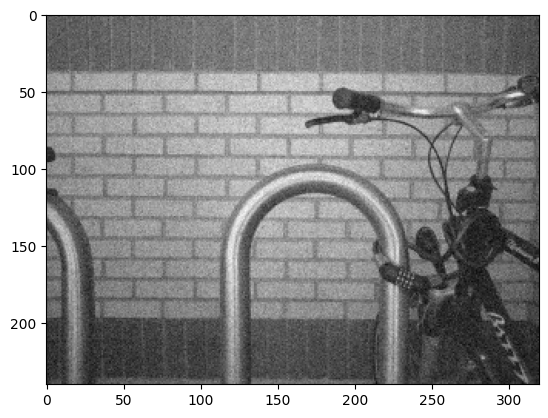

In [42]:
bikes = imageio.imread("../data/bikesgray.jpg").astype(np.float32) / 255.0
bikes = skim.transform.rescale(bikes, 0.5, anti_aliasing=True)
bikes = bikes + np.random.randn(*bikes.shape) * 0.05

util.imshow_gray(bikes)

In [44]:
dx = np.array([-1, 0, 1]).reshape((1, 3)) / 2
dy = dx.T

**Look at `filtering.py`**
* I tweaked our `filter` function to handle non-square kernels.
* I added a `convolve` that just flips the kernel then runs `filter`

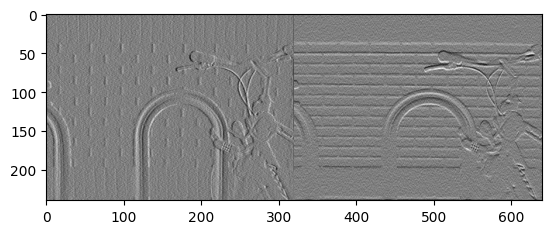

In [45]:
bx = filtering.filter(bikes, dx)
by = filtering.filter(bikes, dy)

util.imshow_gray(np.hstack([bx, by]))

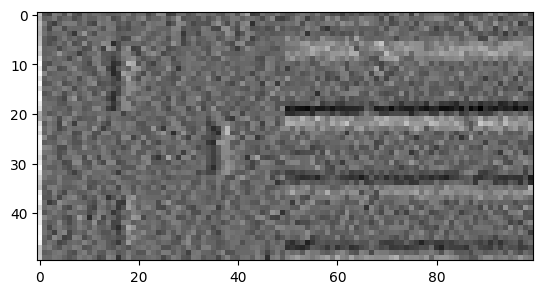

In [46]:
util.imshow_gray(np.hstack([bx[30:80, :50], by[30:80, :50]]))

Let's look at the intensities along a single scanline. This one is a vertical scanline that crosses the brick pattern.

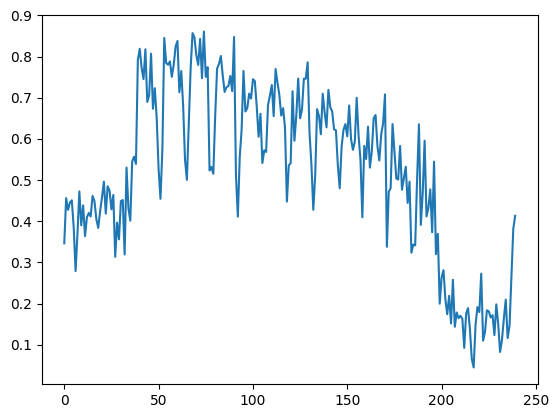

In [47]:
plt.plot(bikes[:,100])

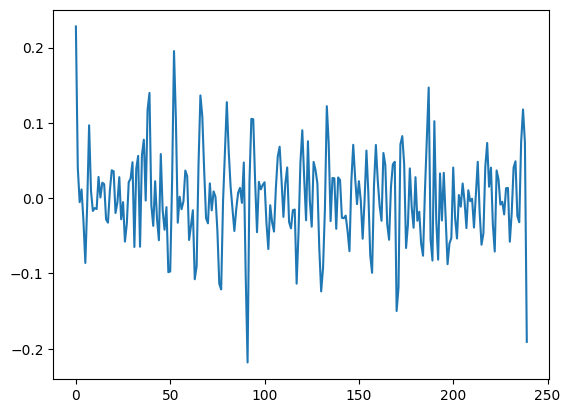

In [48]:
plt.plot(by[:,100])

This motivates an idea: blur the noise so that the real edges stick out!

Why use 2 filters when you could use just 1?

##### Homework Problem 2

Compute the following convolution using zero padding and describe the effect of the resulting kernel in words.
   $$
   \begin{bmatrix}
     1 & 2 & 1\\
     2 & 4 & 2\\
     1 & 2 & 1
   \end{bmatrix} *
   \begin{bmatrix}
     0 & 0 & 0\\
     1 & 0 & -1\\
     0 & 0 & 0
   \end{bmatrix} = 
   \begin{bmatrix}
     \  & \ & \ \\
     \ & \ & \ \\
     \hspace{1em} & \hspace{1em} & \hspace{1em}
   \end{bmatrix}
   $$

Let's check our work:

In [54]:
blur = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]], dtype=np.float32)

dx = np.array([
    [0, 0,  0],
    [1, 0, -1],
    [0, 0,  0]], dtype=np.float32)

# check our answer
xsobel = filtering.convolve(blur, dx)
ysobel = xsobel.T
xsobel

array([[ 2.,  0., -2.],
       [ 4.,  0., -4.],
       [ 2.,  0., -2.]], dtype=float32)

This is more often written scaled down by 1/2:

In [55]:
xsobel /= 2
ysobel = xsobel.T 
xsobel, ysobel

(array([[ 1.,  0., -1.],
        [ 2.,  0., -2.],
        [ 1.,  0., -1.]], dtype=float32),
 array([[ 1.,  2.,  1.],
        [ 0.,  0.,  0.],
        [-1., -2., -1.]], dtype=float32))

Two theories for why - you'll get the 1/2/1 version if you:
* Use repeat padding instead of zero padding in the above convolution
* Derive this from two separable 1D filters (`[1, 2, 1]` and `[1, 0, -1].T`)


### Back to Bikes!

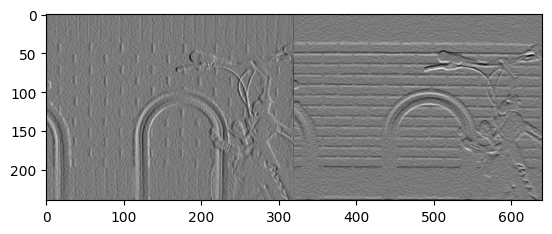

In [56]:
bx = filtering.convolve(bikes, xsobel)
by = filtering.convolve(bikes, ysobel)

util.imshow_gray(np.hstack([bx, by]))

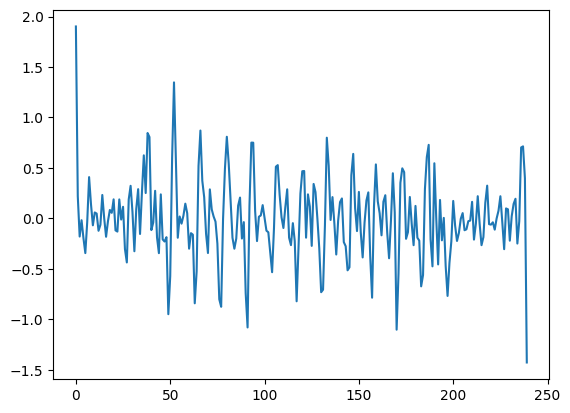

In [57]:
plt.plot(by[:,100])

### From sobel to edge detection

Direction-independent edge detector?
First pass: gradient magnitude

$$ \Delta f =
\begin{bmatrix}
\frac{\partial}{\partial x}  f \\
\frac{\partial}{\partial y}  f
\end{bmatrix}
$$
Edge strength: gradient magnitude $||\Delta f||$

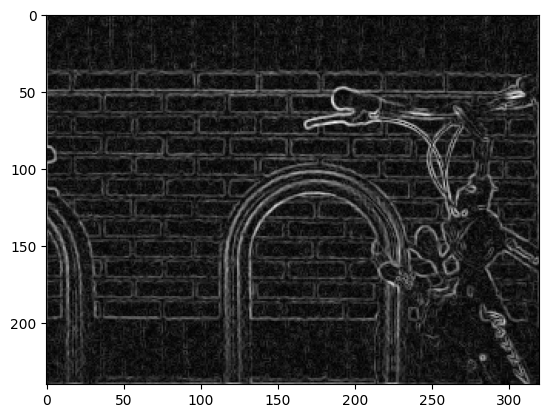

In [58]:
plt.imshow(np.sqrt(bx ** 2 + by**2), cmap="gray")

This is useful enough that I wrote `filtering.grad_mag` to make it simple to do.

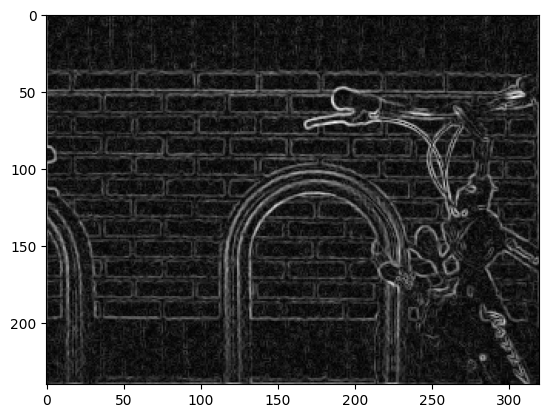

In [59]:
util.imshow_gray(filtering.grad_mag(bikes))

Classical fancier method: [**Canny Edge Detector**](https://en.wikipedia.org/wiki/Canny_edge_detector#Walkthrough_of_the_algorithm)
* Convert to grayscale
* Blur with 5x5 $\sigma=1.4$ Gaussian
* Calculate gradient magnitude
* Apply non-maximum suppression
* Threshold with 2 cutoffs for strong edges, weak edges, and non-edges
* Preserve only weak edges that connect to strong edges

## Spatial Frequency

Whiteboard - intuition (only) for the Fourier decomposition

#### Introducing: the Frequencyometer(TM)
A very imprecise way of talking about what spatial frequencies are present in an image.

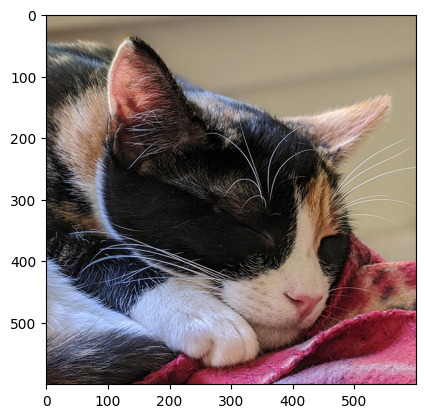

In [64]:
beans = imageio.imread("../data/beans.jpg").astype(np.float32) / 255.0
bg = skim.color.rgb2gray(beans) # grayscale beans

plt.imshow(beans)

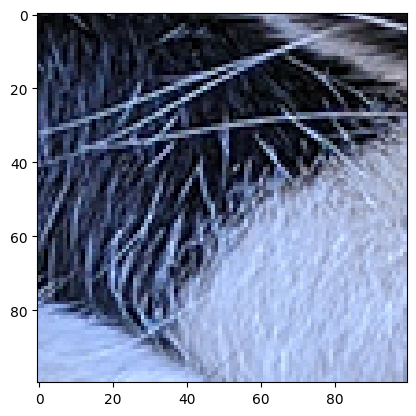

In [61]:
plt.imshow(beans[400:500, 100:200])

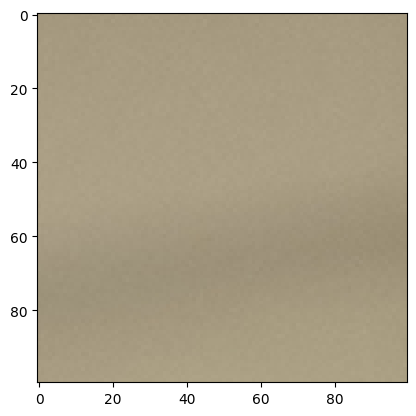

In [62]:
plt.imshow(beans[20:120, 500:600])

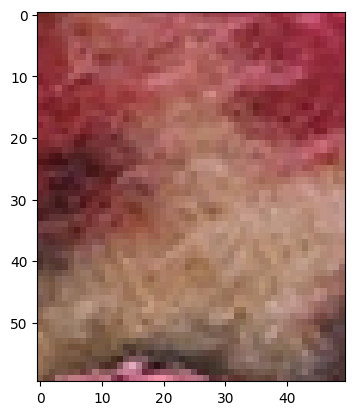

In [63]:
plt.imshow(beans[420:480, 550:600])